In [12]:
# import os
import sys
import json
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import skimage.morphology as morph

sys.path.append("code/preprocessing/")
from utils.file_handling import *
from utils.segment2D     import get_pixel_size


In [13]:
pix_to_um = get_pixel_size()

In [53]:
dataset   = "holomonitor_20240317_B1-1"
config    = json.load(open(f"data/experimental/configs/{dataset}.json"))
im_areas  = np.load(f"data/experimental/processed/{dataset}/im_cell_areas_corrected.npy")
#im_tracked = np.load(f"data/experimental/processed/{dataset}/im_cell_areas_tracked.npy")
im_height = import_stack(f"data/experimental/raw/{dataset}/", config)

cellprops = [regionprops(im_areas[i], im_height[i]) for i in range(len(im_areas))]


FileNotFoundError: [Errno 2] No such file or directory: 'data/experimental/processed/holomonitor_20240317_B1-1/im_cell_areas_corrected.npy'

In [43]:
# for f in range(10, 5, -1):
#     # highest label of region in this frame
#     max_label = np.max(im_tracked[f-5])

#     # identify all labels of emtpy cell regions
#     empty_labels = np.unique(im_areas[f][im_tracked[f-5] == 0])[1:]

#     for label in empty_labels:

#         # isolate empty cell region
#         empty_mask = im_areas[f] == label

#         #find labels in im_areas of next frame
#         labels, freq = np.unique(im_areas[f+1][empty_mask], return_counts=True)
#         freq = freq[labels > 0] / np.sum(freq[labels > 0])
#         labels = labels[labels > 0]

#         # 4) keep if more than 10 % (?)
#         labels = labels[freq>0.1]
#         combined_mask = empty_mask * np.isin(im_areas[f+1], labels)
            
#         # 5) add region to empty cell region

#         new_region = np.array(combined_mask, dtype=int) * im_tracked[f+1-5] + max_label
#         new_region = morph.dilation(new_region, morph.disk(10))

#         im_tracked[f-5][combined_mask] = new_region[combined_mask]



In [44]:
# obtain arrays
Acells = np.concatenate([[cell.area for cell in cells] for cells in cellprops])
hcells = np.concatenate([[cell.mean_intensity for cell in cells] for cells in cellprops])
Lcells = np.concatenate([[cell.label for cell in cells] for cells in cellprops])
Fcells = np.concatenate([[frame for cell in cellprops[frame]] for frame in range(len(cellprops))])
pos_cells = np.concatenate([[cell.centroid_weighted for cell in cells] for cells in cellprops])


In [46]:
a_scale = 50

cells_df = pd.DataFrame({'x': pos_cells.T[1],
                         'y': pos_cells.T[0],
                         'area': Acells / a_scale,
                         'hmean': hcells,
                         'label': Lcells, 
                         'frame': Fcells})

# track cells
thres = 6
memory = 5
search_range = 10
tracks = tp.link(cells_df, search_range=search_range, memory=memory, pos_columns=['x', 'y', 'hmean', 'area']);
tracks = tp.filter_stubs(tracks, threshold=thres);

# compute displacement
dr = np.sqrt(tracks.groupby('particle')['x'].diff()**2 + tracks.groupby('particle')['y'].diff()**2).values
dA = tracks.groupby('particle')['area'].diff().values
dh = tracks.groupby('particle')['hmean'].diff().values

# compute track length
track_length = [np.sum(tracks['particle'] == p_id) for p_id in np.unique(tracks['particle'])]

# compute number of cells
Ncells = [np.sum(tracks['frame'] == f) for f in np.unique(tracks.frame)]
frames = np.arange(thres, len(Ncells)-thres)

# plot result
#fig, ax = plt.subplots(2,3, figsize=(12,6))
tp.plot_traj(tracks, ax=ax[0,0])
ax[0,1].hist(dr)
ax[0,2].hist(track_length);
ax[1,0].plot(Ncells, '.', label=thres)
ax[1,0].plot(frames, Ncells[thres:-thres], '.', label=thres)

ax[1,1].hist(Acells)
ax[1,2].hist(dA*a_scale)

ax[1,1].set(yscale='log')
ax[1,2].set(yscale='log')

ax[0,1].set(xlabel="dr (px)", yscale="linear")
ax[0,2].set(xlabel="track length (frames)")
fig.tight_layout()


tracks = tracks[(tracks.frame >=(thres-1)) * (tracks.frame < np.max(tracks.frame)+1-(thres-1))]

Frame 160: 632 trajectories present.


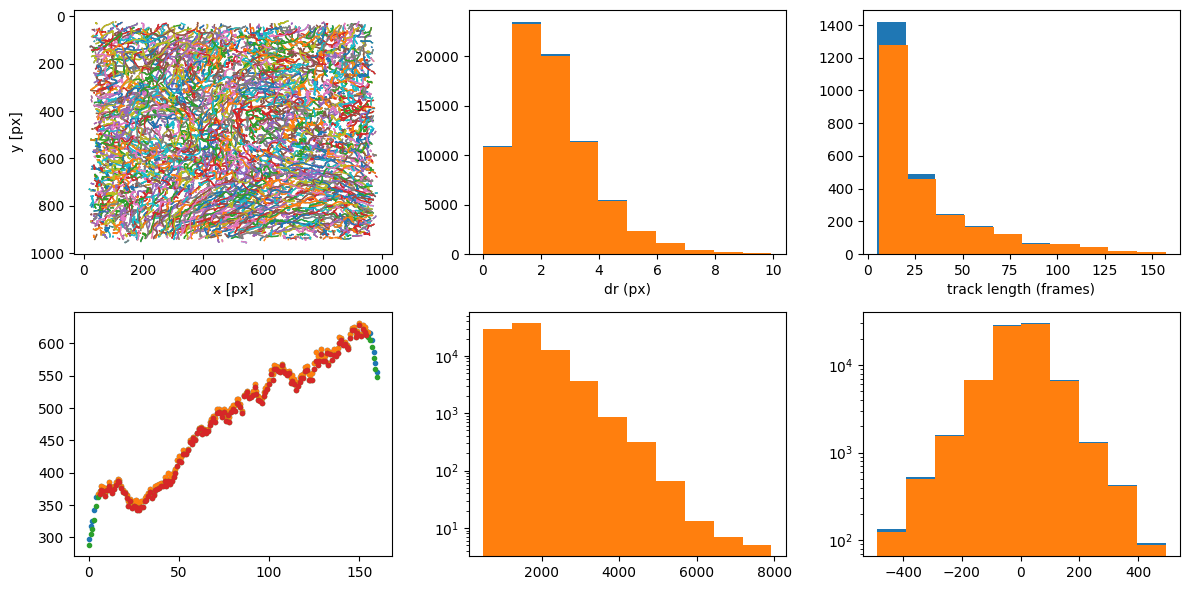

In [47]:
fig

In [ ]:
# keep only frames where all cells can have tracks longer than thres
#tracks = tracks[(tracks.frame >=(thres-1)) * (tracks.frame < np.max(tracks.frame)+1-(thres-1))]

im_tracked = np.copy(im_areas)[5:-4]

for i in range(len(im_tracked)):
    labels = tracks[tracks.frame==5+i].label.values
    exclude = np.setdiff1d(np.unique(im_areas[5+i]), labels)

    for cell in exclude:
        mask = im_tracked[i] == cell
        im_tracked[i][mask] = 0

In [ ]:
# keep only frames where all cells can have tracks longer than thres
im_tracked_new = np.copy(im_areas)[5:-4]

labels = tracks[tracks.frame==5].label.values
exclude = np.setdiff1d(np.unique(im_areas[5]), labels)

for cell in exclude:
        mask = im_tracked_new[i] == cell
        im_tracked_new[0][mask] == 0

for i in range(len(im_tracked_new)-1):
    labels = tracks[tracks.frame==5+i].label.values
    exclude = np.setdiff1d(np.unique(im_areas[5+i]), labels)

    for cell in exclude:
        mask = im_tracked_new[i] == cell
        im_tracked_new[i][mask] == im_tracked_new[i-1][mask]

In [96]:
labels = tracks[tracks.frame==5].label.values
exclude = np.setdiff1d(np.unique(im_areas[5]), labels)
im_tracked_new = np.copy(im_areas)[5:-4]

for cell in exclude:
    mask = im_tracked_new[i] == cell
    im_tracked_new[0][mask] == im_tracked_new[1][mask]

In [108]:
im_tracked[1][(im_tracked_new[0]==3)]

array([ 0,  0, 65, ...,  0,  0,  0], shape=(2849,))

In [269]:
np.save(f"data/experimental/processed/{dataset}/im_cell_areas_tracked.npy", im_tracked)

In [6]:
x_raw = tracks.pivot(index='frame', columns='particle', values='x').to_numpy()
y_raw = tracks.pivot(index='frame', columns='particle', values='y').to_numpy()
A_raw = tracks.pivot(index='frame', columns='particle', values='area').to_numpy() * pix_to_um[1]**2
h_raw = tracks.pivot(index='frame', columns='particle', values='hmean').to_numpy()
l_raw = tracks.pivot(index='frame', columns='particle', values='label').to_numpy()

x_raw = np.ma.masked_where(np.isnan(x_raw), x_raw)
y_raw = np.ma.masked_where(np.isnan(y_raw), y_raw)
A_raw = np.ma.masked_where(np.isnan(A_raw), A_raw)
h_raw = np.ma.masked_where(np.isnan(h_raw), h_raw)
l_raw = np.ma.masked_where(np.isnan(l_raw), l_raw)
V_raw = h_raw * A_raw

In [48]:
V1_arr = []
V2_arr = []
idx_arr = []

idx_division = []
idx_outlier = []
idx_split = []
idx_other = []
idx_normal = []

particle = []
std_arr = []

len_min = 24

i = 0
for p in np.unique(tracks['particle']):

    tmp_df = tracks[tracks.particle == p]
    if len(tmp_df) < 2:
        continue
    
    V = (tmp_df.hmean * tmp_df.area*a_scale).values

    V_median = np.ma.median(V)
    dV = np.diff(V)
    particle.append(p)

    idx = np.argmax(abs(dV))
    idx_arr.append(idx+1)

    V1 = np.ma.median(V[idx-10:idx])
    V2 = np.ma.median(V[idx:idx+10])
    V1_arr.append(V1)
    V2_arr.append(V2)
    
    if np.max(abs(dV)) / V_median > 0.4 and np.sum(V>0)>len_min:


        idx_split.append(i)

    elif np.sum(V>0)>len_min:
        idx_normal.append(i)
        
    i += 1

/home/silja/Documents/MDCK_QPI/mdck_venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/silja/Documents/MDCK_QPI/mdck_venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
len(idx_normal), len(idx_split), len(idx_normal)+ len(idx_split)

(922, 64, 986)

In [50]:
#  for p in p_division:

#     # Create a mask to identify rows where the frame is greater than the split_frame
#     mask = (tracks.particle == p_particle[p]) * (tracks.frame > idx_arr[p]+5)

#     # Generate a new particle ID for rows after the split_frame
#     tracks.loc[mask, 'particle'] = tracks.loc[mask, 'particle'] + tracks['particle'].max()  # Update IDs



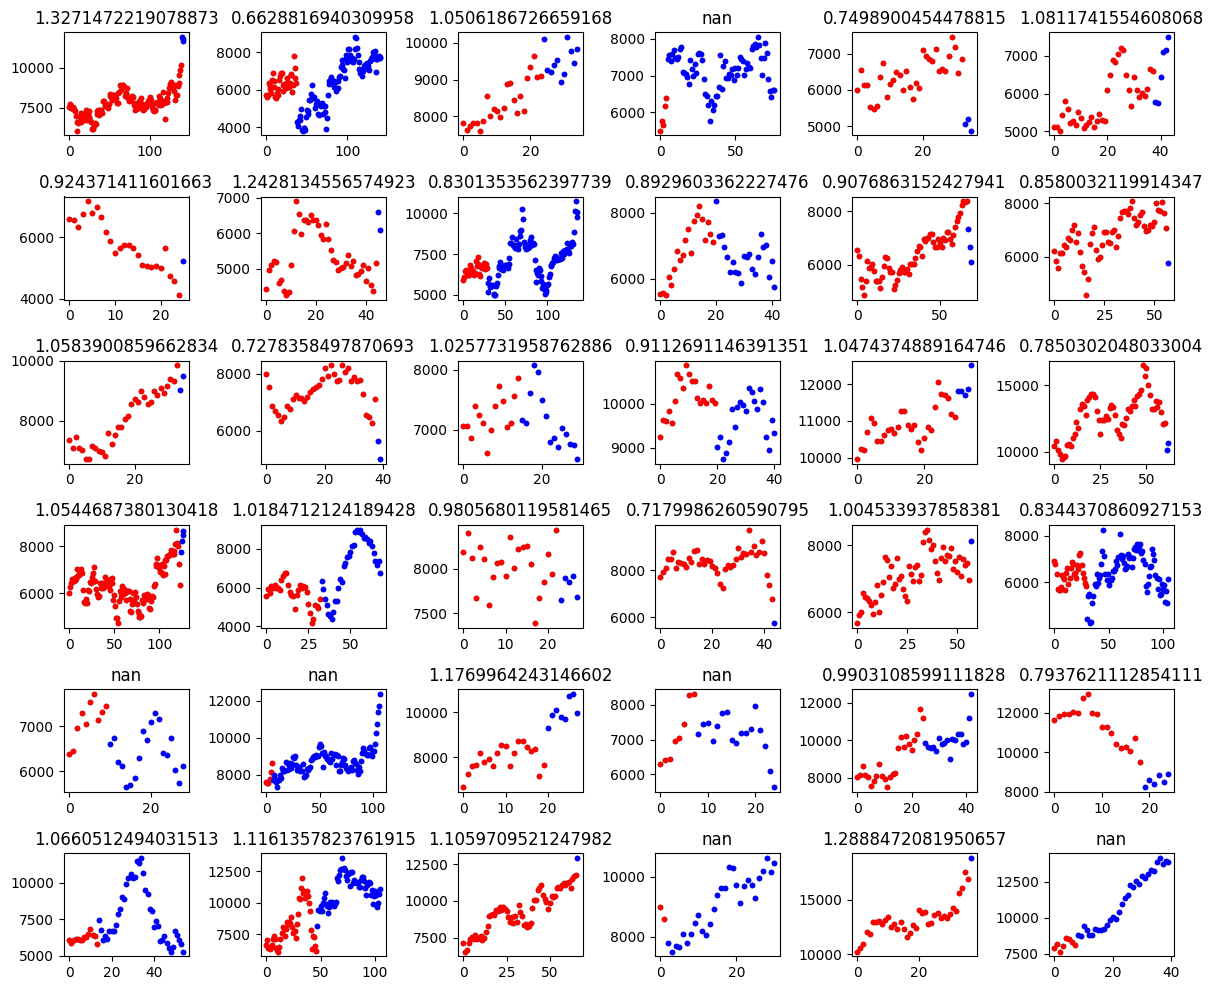

In [52]:
fig, ax = plt.subplots(6, 6, figsize=(12,10))

i = 0
for p, axes in zip(idx_normal[0:], ax.flatten()):

    tmp_df = tracks[tracks.particle == particle[p]]
    #V = tmp_df.area.values 
    #h = tmp_df.hmean.values
    V=(tmp_df.hmean * tmp_df.area*a_scale).values

    frame = np.arange(len(V))

    axes.plot(frame, V, 'k.', label=p)
    #axes.plot(frame, 100/h, 'c.', label=p)
    axes.plot(frame[:idx_arr[p]], V[:idx_arr[p]],'r.', label=p)
    axes.plot(frame[idx_arr[p]:], V[idx_arr[p]:],'b.', label=p)

    axes.set(title=f"{np.round((V2_arr[p])) / np.round(V1_arr[p])}")

    i+=1

fig.tight_layout()

In [ ]:
# start from longest track
# np.isnan
# if missing frame in the middle: 
# fill in missing frames x and y position as mean of before and after

x_raw = tracks.pivot(index='frame', columns='particle', values='x').to_numpy()
y_raw = tracks.pivot(index='frame', columns='particle', values='y').to_numpy()
A_raw = tracks.pivot(index='frame', columns='particle', values='area').to_numpy() * pix_to_um[1]**2
h_raw = tracks.pivot(index='frame', columns='particle', values='hmean').to_numpy()
p_raw = tracks.pivot(index='frame', columns='particle', values='particle').to_numpy()
f_raw = tracks.pivot(index='frame', columns='particle', values='frame').to_numpy()


In [480]:
mask = np.sum(A_raw > 0, axis=0) == 128
np.sort(np.sum(A_raw > 0, axis=0)), np.sum(mask)

(array([  1,   1,   1, ..., 129, 129, 129], shape=(1817,)), np.int64(1))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

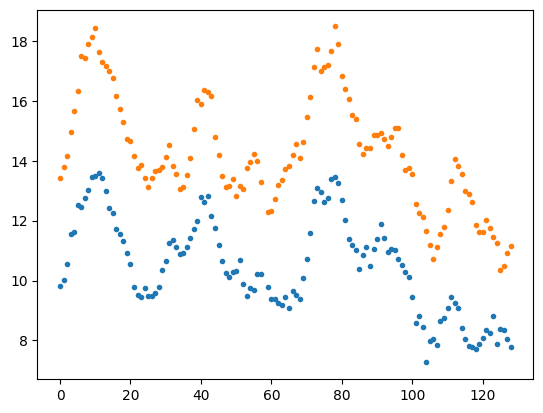

In [ ]:
plt.plot(A_raw[:,mask], '.')
plt.plot(60/h_raw[:,mask], '.')

In [504]:
f_raw[63-5,238], np.isnan(y_raw[:,238])

(np.float64(nan),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fa